## Results of point pollution dilbit spill scenarios at Turn Point
Plotting functions for comparing survival and recovery of groups of species within a single model scenario from the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

### Define scenario and control files

In [56]:
# Read in salish sea atlantis output files.
# scenario_path = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
# scens = sorted([p for p in scenario_path.glob('*Scenario_5b*/outputSalishSeaBiomIndx.txt')])

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/control_v6666mod/outputSalishSea.nc"
scenario1_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2019-01-14_redo/outputSalishSea.nc" #neap
scenario2_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2019-01-20/outputSalishSea.nc" #spring
scenario3_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2020-01-11_28/outputSalishSea.nc" #spring
scenario4_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2020-01-16_28/outputSalishSea.nc" #neap

control = xr.open_dataset(str(control_file), decode_cf=True)
scenario1 = xr.open_dataset(str(scenario1_file), decode_cf=True)
scenario2 = xr.open_dataset(str(scenario2_file), decode_cf=True)
scenario3 = xr.open_dataset(str(scenario3_file), decode_cf=True)
scenario4 = xr.open_dataset(str(scenario4_file), decode_cf=True)

time = np.ma.filled(control.variables['t'], np.nan)


In [57]:
scenarios = [scenario1, scenario2, scenario3, scenario4]
scenarios2019 = [scenario1, scenario2]
scenarios2020 = [scenario3, scenario4]

In [170]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [195]:
def map_pelagic_single_time(variable_name, scenarios, control, time, time_index, start, end, event_start, v_max=100, v_min=-100):
    # map of single variable ratio at a specific time index

    line_width = 2
    font_size = 12
    label_size = 10
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.coolwarm # RdGy_r #cm.PuOr_r cm.bwr cm.ocean_r 

    ts_date = np.array(time[time_index])

    dVar_control = control.variables[variable_name]
    dVar_control = dVar_control.sum(axis=2)
    box_sum_control = dVar_control.sum(axis=1)
    control_ratio = (box_sum_control / box_sum_control-1)*100

    fig = plt.figure(figsize=(18, 12), facecolor='white')
    gs = plt.GridSpec(2, len(scenarios), height_ratios=[1, 3])
    ax_ts = fig.add_subplot(gs[0,:])
    ax_ts.plot(event_start, 0, 'ro', alpha=0.4)
    ax_ts.plot([ts_date, ts_date], [-10, 10], 'k--')
    ax_ts.plot(time[start:end], control_ratio[start:end], 'k', linewidth = line_width)
    ax_ts.set_title('Percent (%) Change in '+ variable_name, fontsize = font_size)

    position = 0
   
    for scenario in scenarios:
        dVar_s = scenario.variables[variable_name]
        dVar_s = dVar_s.sum(axis=2)
        box_sum_scenario = dVar_s.sum(axis=1) 
        scenario_ratio = (box_sum_scenario / box_sum_control-1)*100

        ## Select specific time period
        tVar_control = dVar_control[time_index,:]
        tVar_s = dVar_s[time_index,:]
        oil_ratio = (tVar_s / tVar_control -1)*100

        # Add scenario data to Atlantis spatial data
        map_df['scen'] = oil_ratio
        map_df.loc[land_boxes, 'scen'] = 0
        
        ax_ts.plot(time[start:end], scenario_ratio[start:end], linewidth = line_width)

        ax = fig.add_subplot(gs[1,position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'scen', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True,
            #legend_kwds={'label': variable_name + ' percent (%) change'},
            )
        ax.set_title('Scenario '+ str(position+1), fontsize = font_size)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white')
        position = position+1
    # sm = plt.cm.ScalarMappable(cmap=_cmap, norm=plt.Normalize(vmin=v_min, vmax=v_max))
    # sm._A = []
    # fig.colorbar(sm)

    #ax= map_df.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);
    ax_ts.set_ylabel('Percent (%) Change', fontsize = font_size)
    ax_ts.legend(['event start','track date','control','scenario 1', 'scenario 2', 'scenario 3', 'scenario 4'], loc='lower left')
    ax_ts.tick_params(labelsize=label_size)

    return

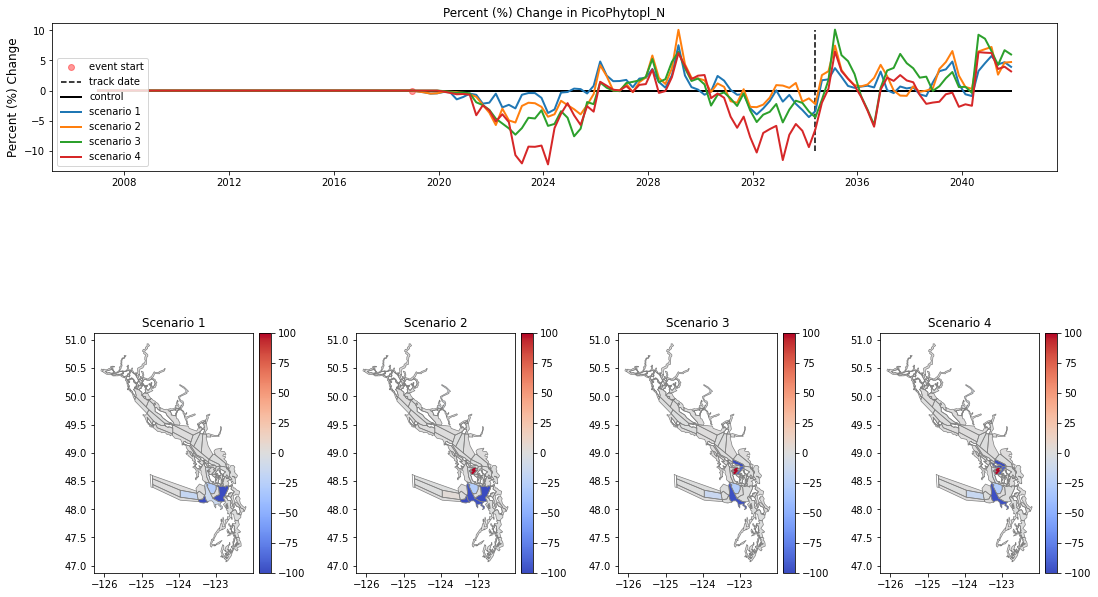

In [196]:
map_pelagic_single_time('PicoPhytopl_N', scenarios, control, time, 110, start, end, spill_start1)

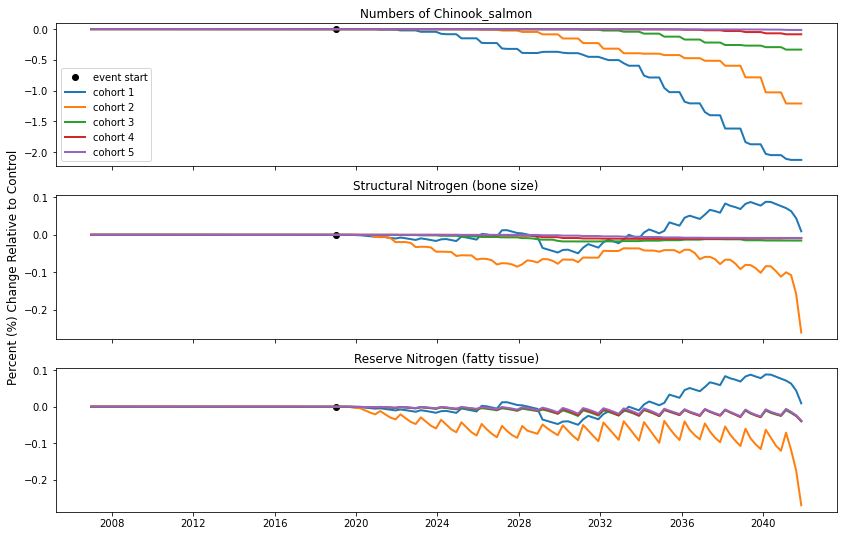

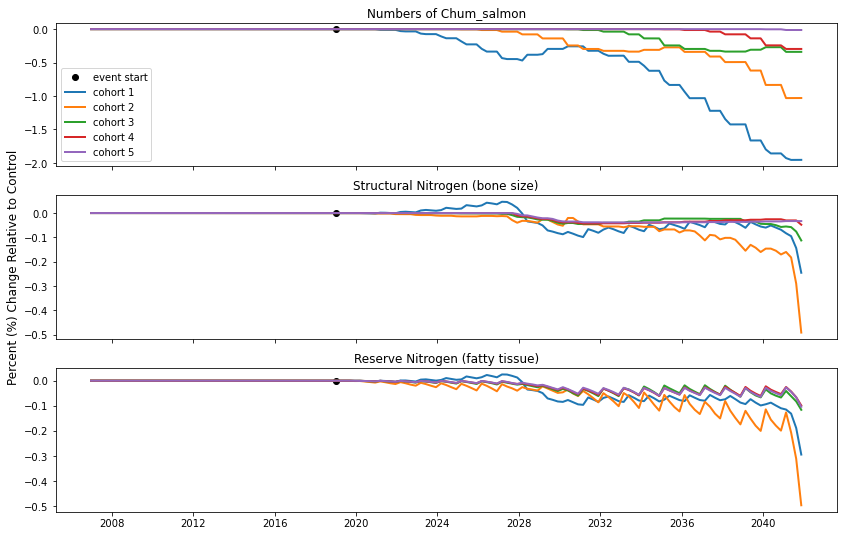

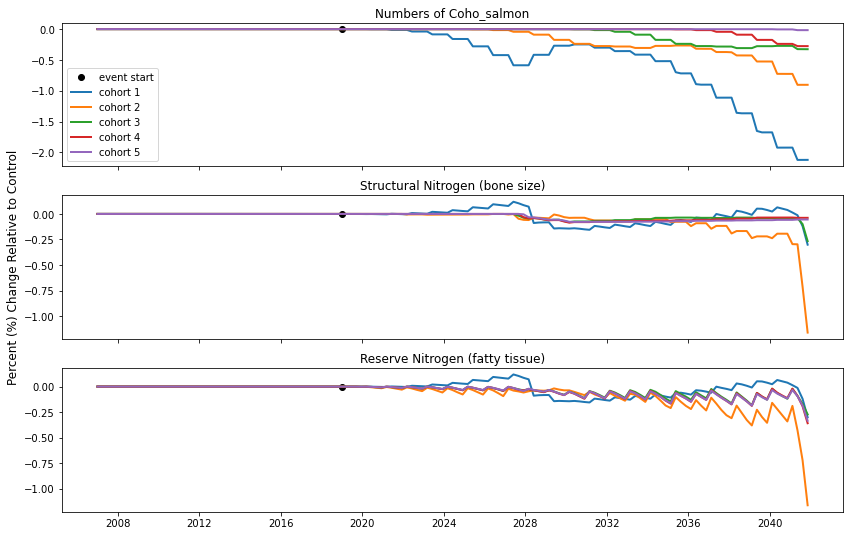

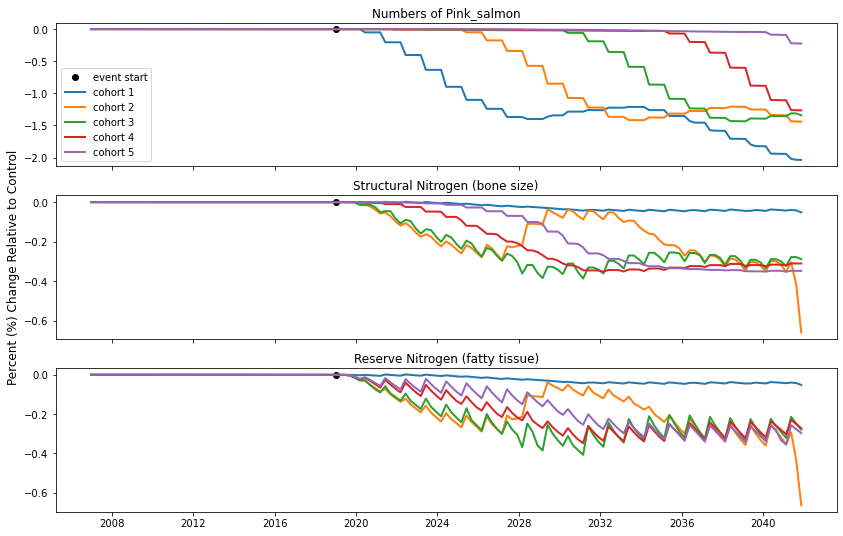

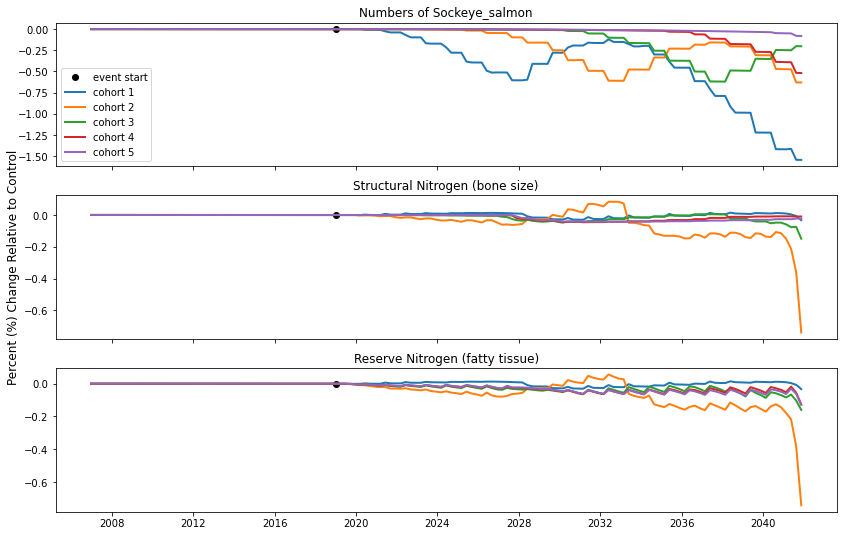

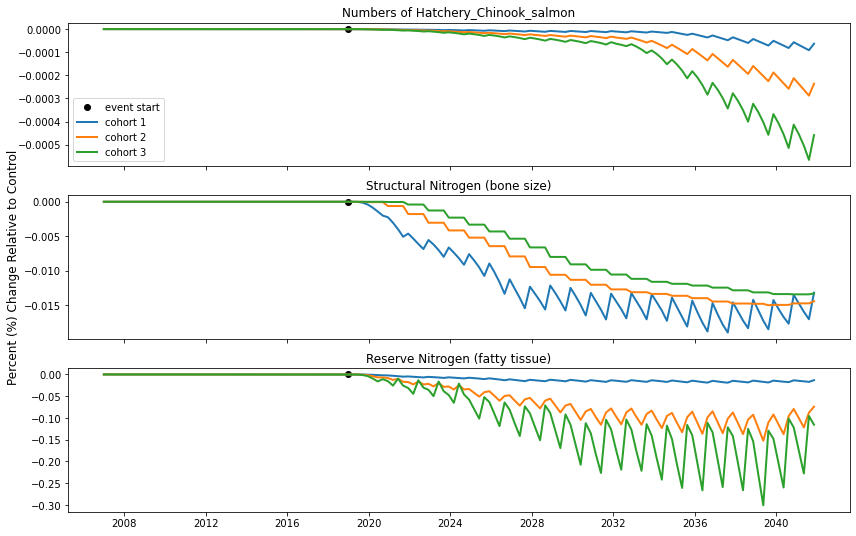

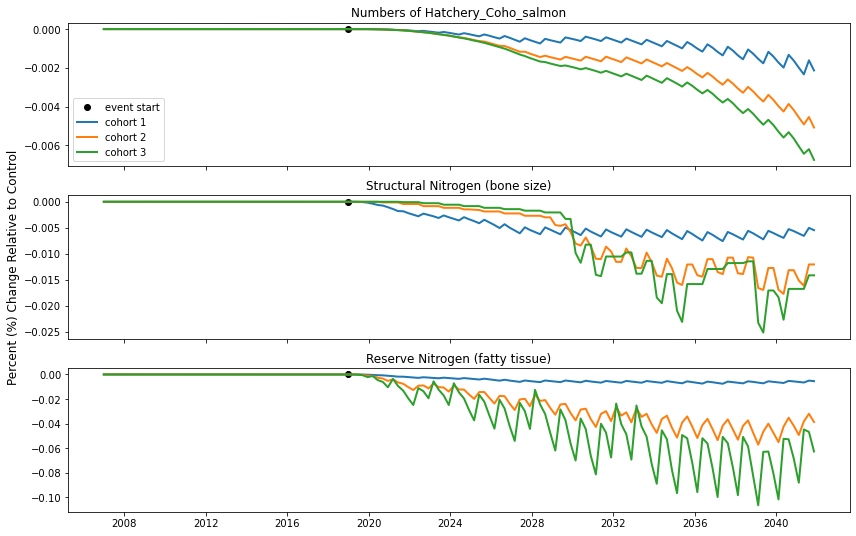

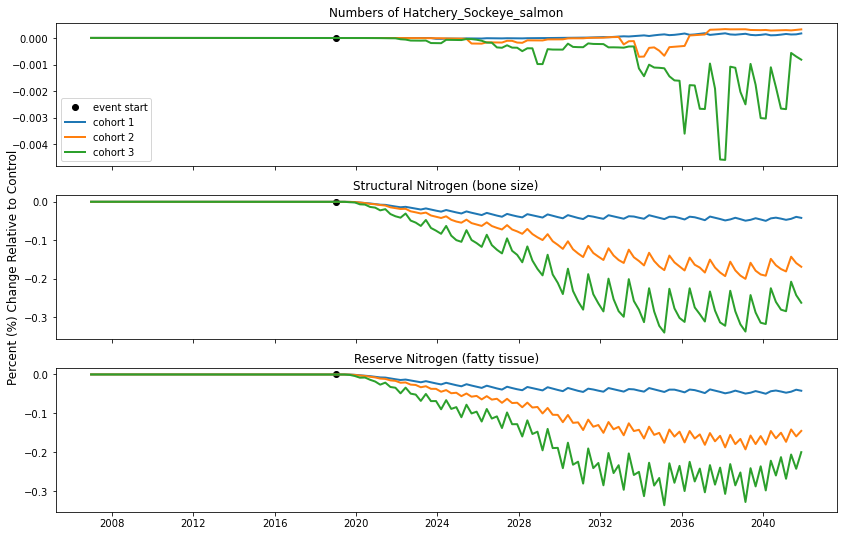

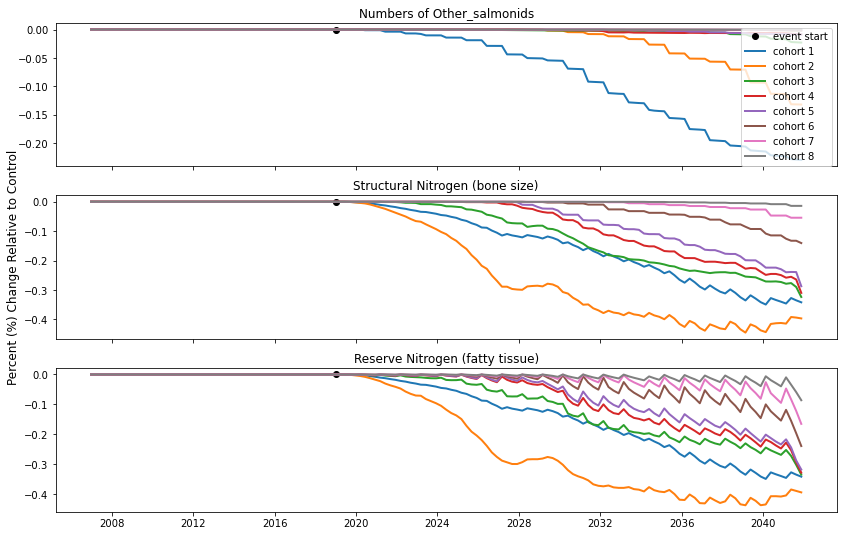

In [96]:
splot.plot_cohorts(groups.salmon, scenario1, control, time, start, end, spill_start1)

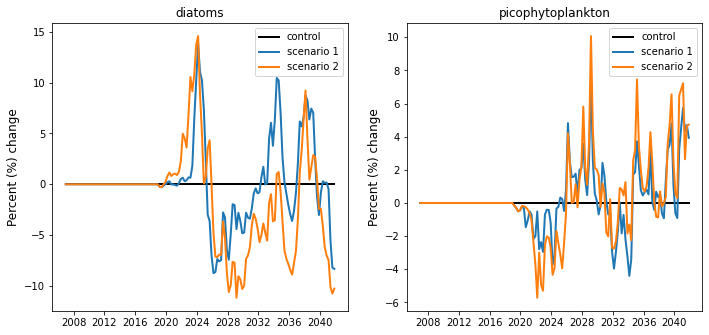

In [69]:
fig = plt.figure(figsize=(18, 18), facecolor='white')
gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

for species in groups.phytoplankton:
     
    bio_index = (list(groups.phytoplankton).index(species))

    if bio_index < 3:
        position = 0, bio_index
    elif bio_index > 5: 
        position = 2, bio_index-6
    else :
        position = 1, bio_index-3

    ax = fig.add_subplot(gs[position])    

    pelagic_control = np.ma.filled(control.variables[groups.plankton[species] + '_N'][start:end,:,0:6], np.nan)
    pelagic_control = pelagic_control.sum(axis=2)
    pelagic_control = pelagic_control.sum(axis=1)
    control_ratio = (pelagic_control / pelagic_control-1)*100
    ax.plot(time[start:end], control_ratio, 'k', linewidth = 2)

    for scenario in scenarios2019:
        pelagic_oiled = np.ma.filled(scenario.variables[groups.plankton[species] + '_N'][start:end,:,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=2) 
        pelagic_oiled = pelagic_oiled.sum(axis=1) 
        ratio = (pelagic_oiled / pelagic_control-1)*100
        ax.plot(time[start:end], ratio,linewidth = 2)
    
    plt.ylabel('Percent (%) change', fontsize=12)
    ax.legend(['control', 'scenario 1', 'scenario 2', 'scenario 3', 'scenario 4'])
    ax.set_title(species)

In [58]:
# start and end time of data display, after burn-in
start = 0
end = t.size-1

spill_start1 = np.datetime64('2019-01-01')
spill_start2 = np.datetime64('2020-01-01')

### Results

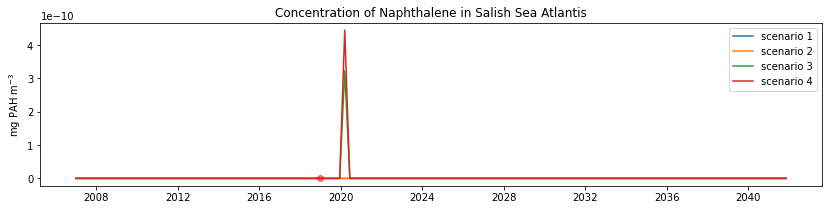

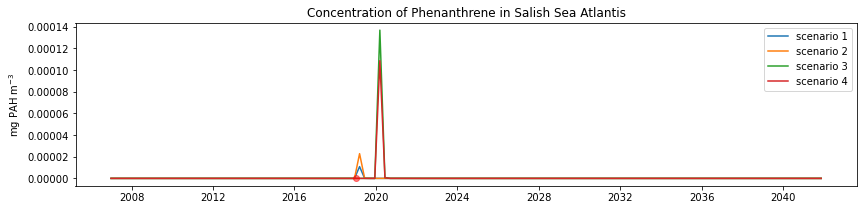

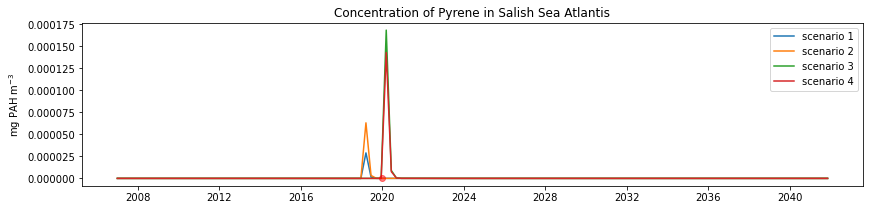

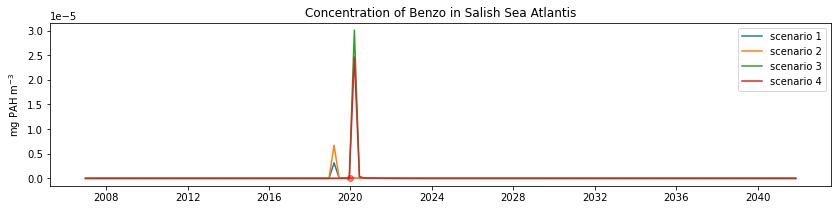

In [5]:
splot.compare_pah('Naphthalene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start1)
splot.compare_pah('Phenanthrene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start1)
splot.compare_pah('Pyrene', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start2)
splot.compare_pah('Benzo', scenario1, scenario2, scenario3, scenario4, time, start, end, spill_start2)

Naphthalene in 2019

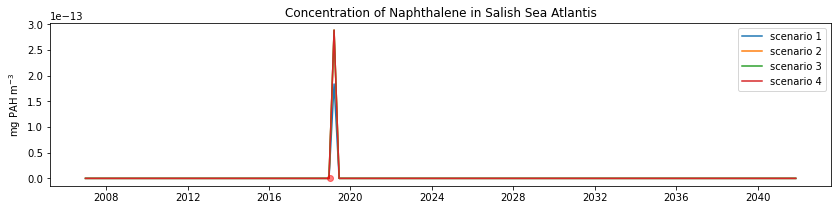

In [6]:
splot.compare_pah('Naphthalene', scenario1, scenario2, scenario2, scenario2, time, start, end, spill_start1)

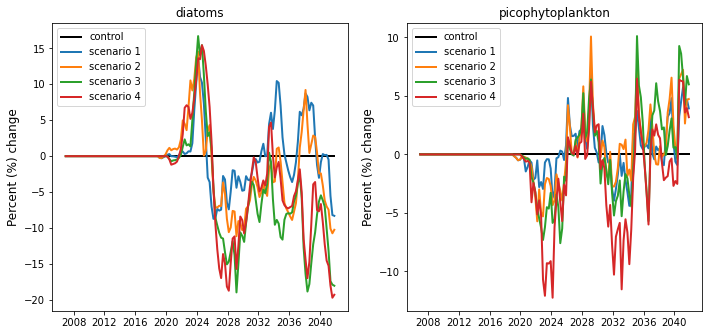

In [7]:
splot.pelagic_compare_scenarios(groups.phytoplankton, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

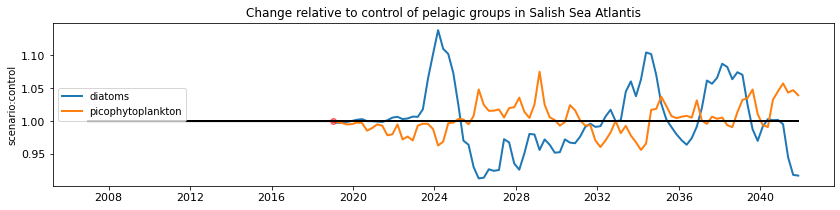

In [8]:
splot.plot_pelagic(groups.phytoplankton, scenario1, control, time, start, end, spill_start1)

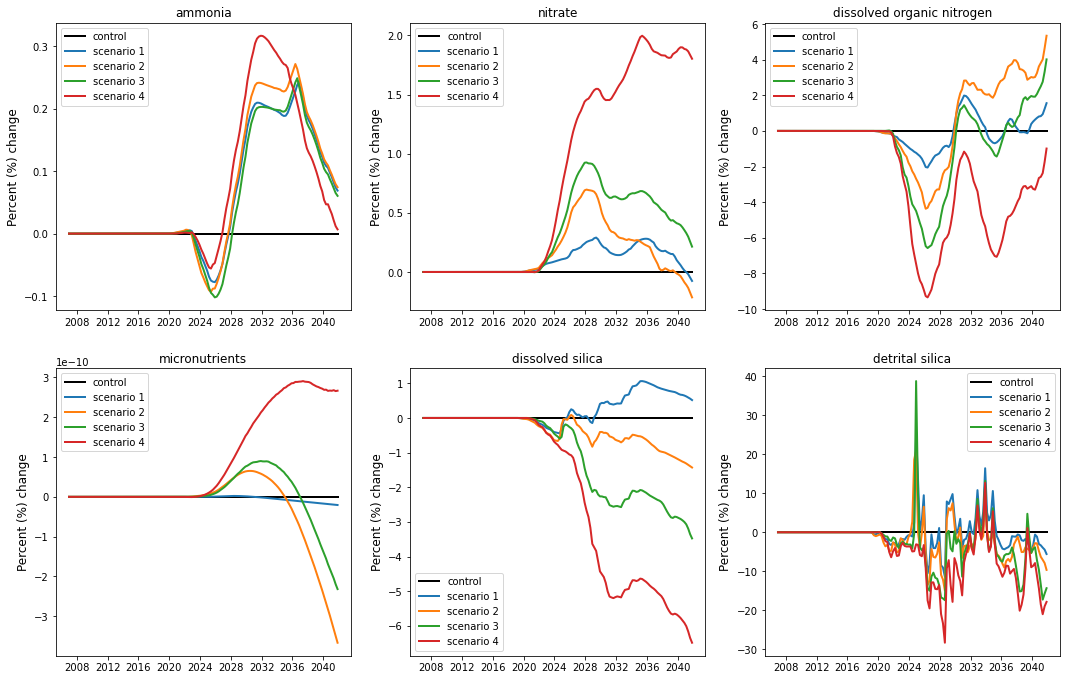

In [10]:
splot.pelagic_compare_nutrients(groups.nutrients, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

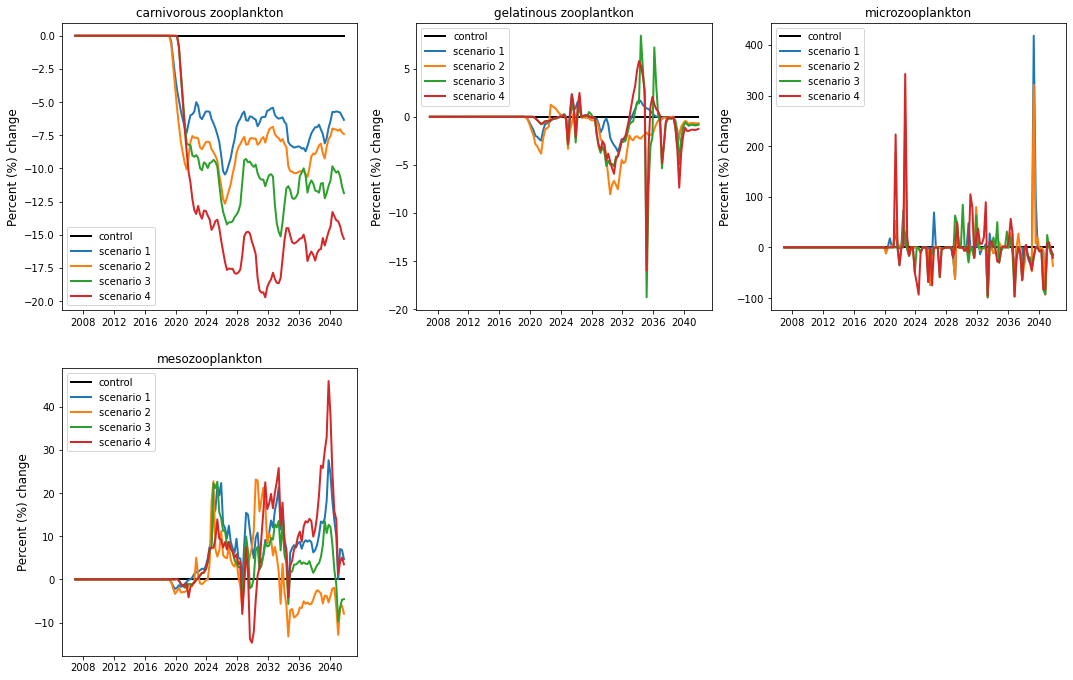

In [11]:
splot.pelagic_compare_scenarios(groups.zooplankton, scenario1, scenario2, scenario3, scenario4, control, time, start, end)

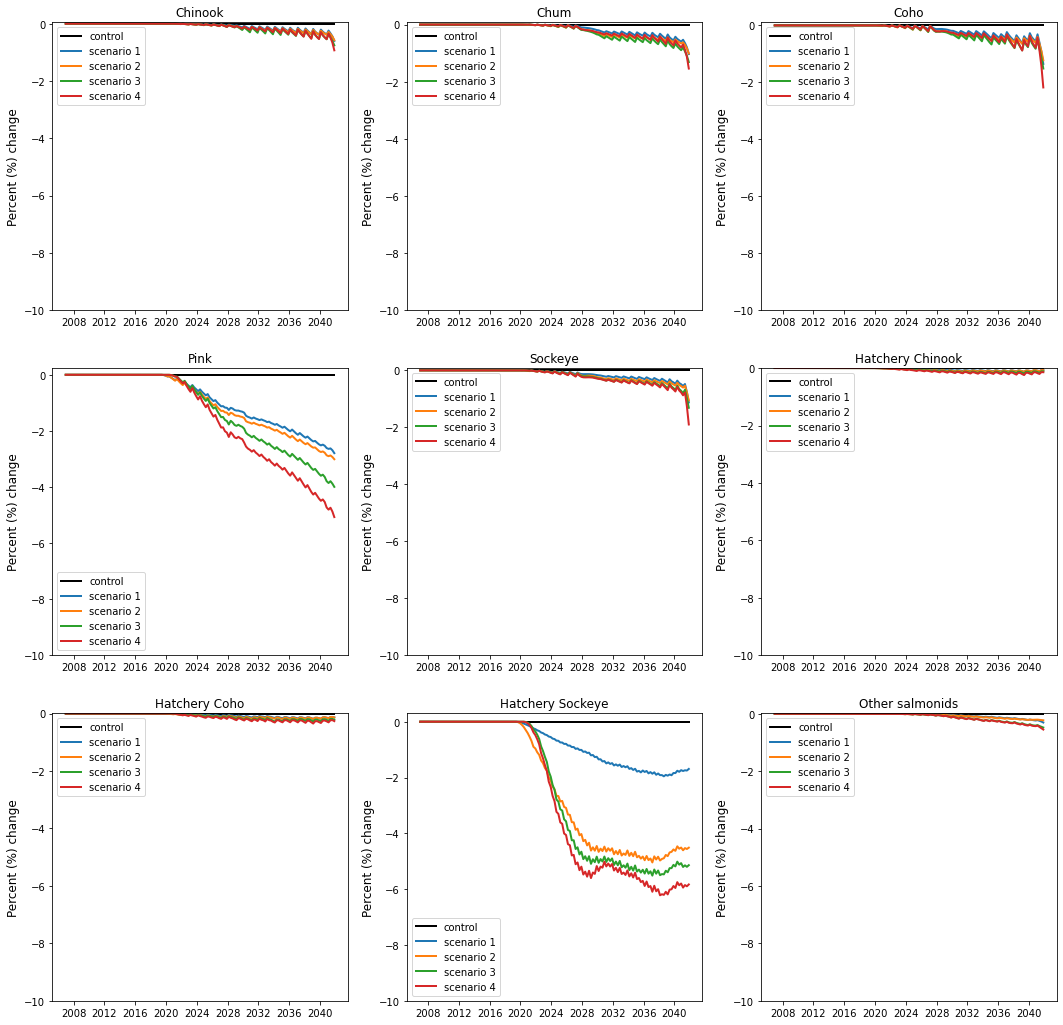

In [12]:
splot.pelagic_compare_scenarios(groups.salmon, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

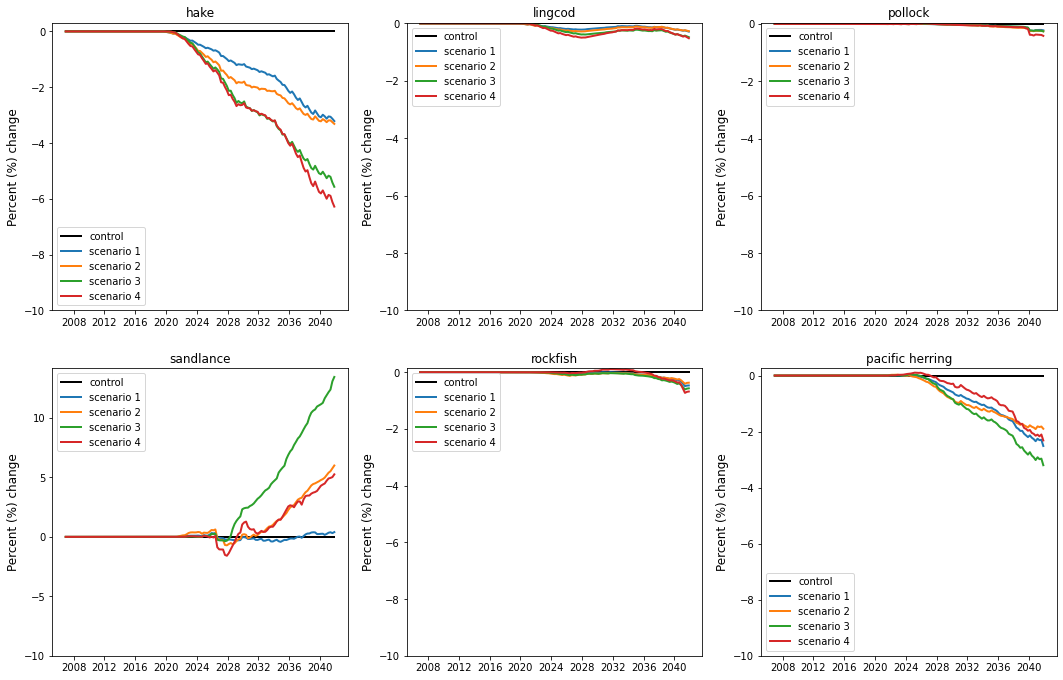

In [13]:
splot.pelagic_compare_scenarios(groups.named_fish, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

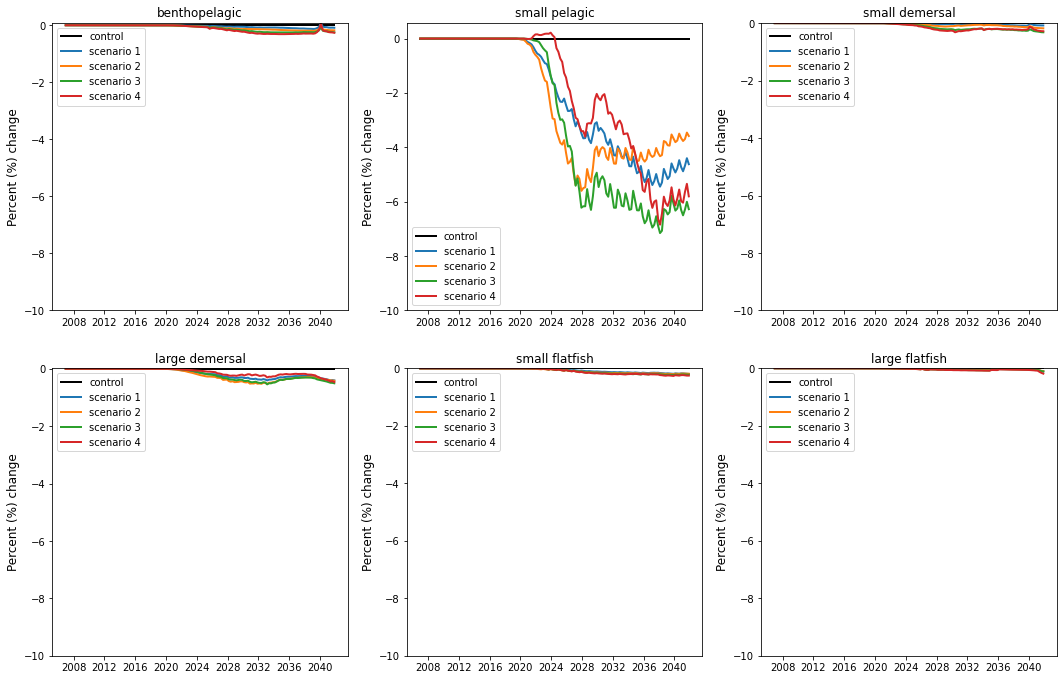

In [14]:
splot.pelagic_compare_scenarios(groups.other_fish, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

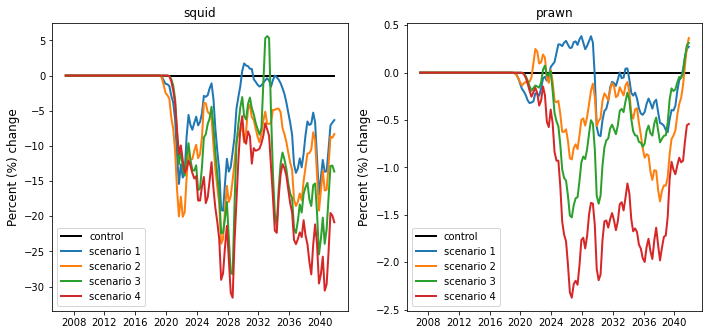

In [29]:
splot.pelagic_compare_scenarios(groups.pelagic_invertebrates, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

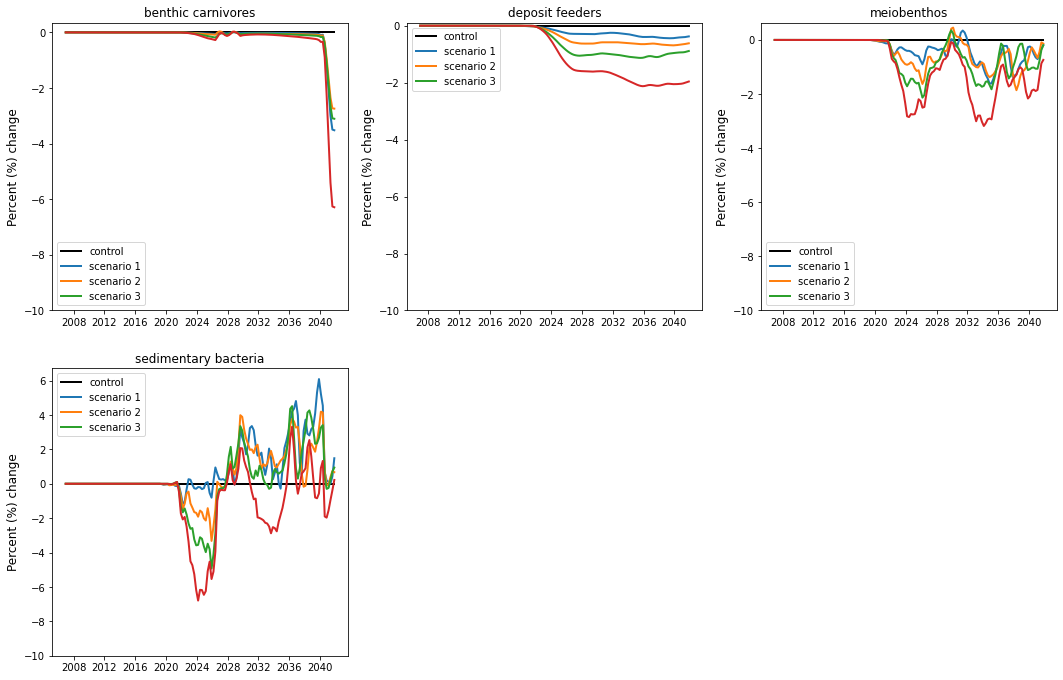

In [16]:
splot.sediment_compare_scenarios(groups.sediment_feeders, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-10, y_max=None)

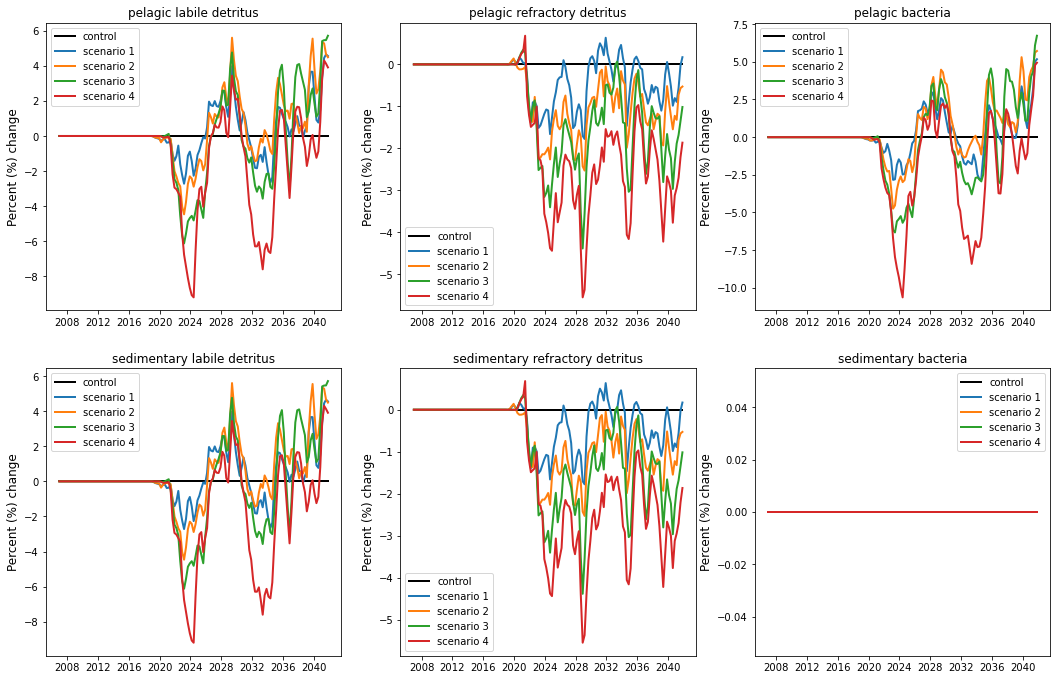

In [17]:
splot.pelagic_compare_scenarios(groups.bacteria, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

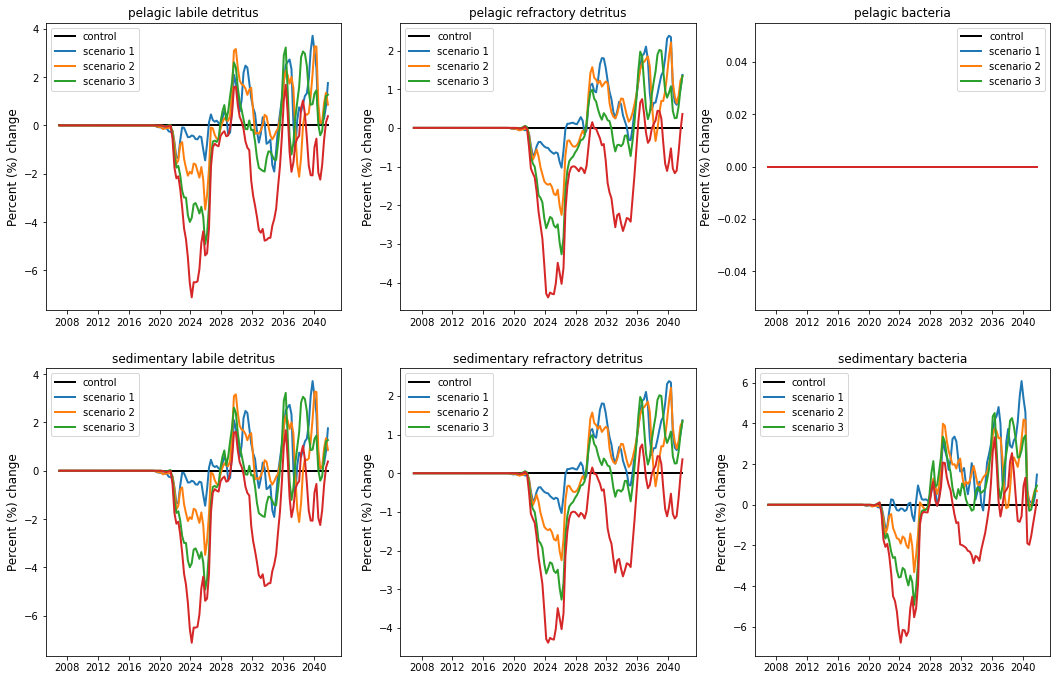

In [18]:
splot.sediment_compare_scenarios(groups.bacteria, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=None, y_max=None)

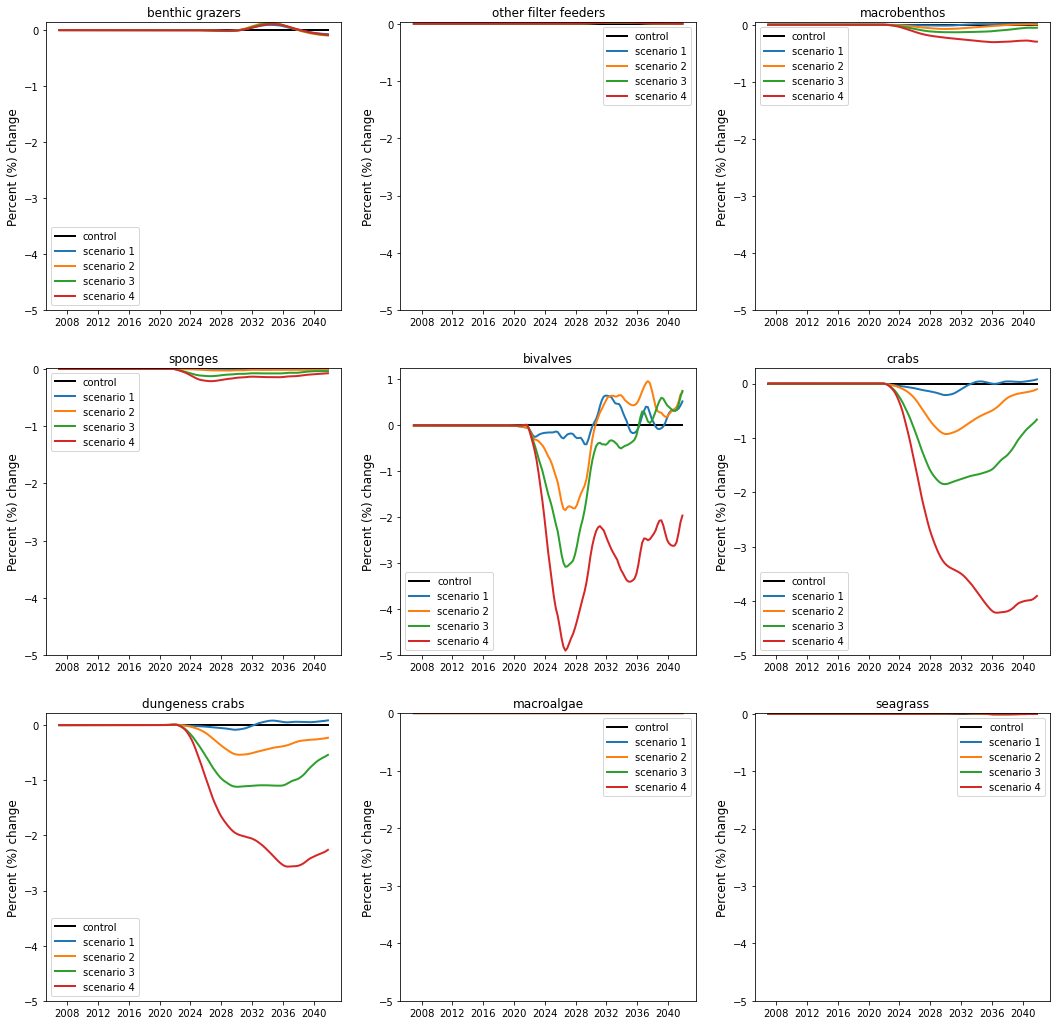

In [19]:
splot.benthic_compare_scenarios(groups.benthos, scenario1, scenario2, scenario3, scenario4, control, time, start, end, y_min=-5, y_max=None)

### Assessing specific periods post-spill

In [20]:
print('closest time points to spill: ' + str(t[49]))
print('5 years post spill: ' + str((t[69])))
print('10 years post spill: ' + str(t[89]))
print('20 years post spill: ' + str(t[129]))

closest time points to spill: 2019-03-13T14:00:00.000000000
5 years post spill: 2024-03-06T14:00:00.000000000
10 years post spill: 2029-02-28T14:00:00.000000000
20 years post spill: 2039-02-16T14:00:00.000000000


In [21]:
days2019winter = [49, 69, 89, 129]
days2020winter = [53, 73, 93, 133]
data_label = {'spill year': [], '5 years later': [], '10 years later': [], '20 years later': []}

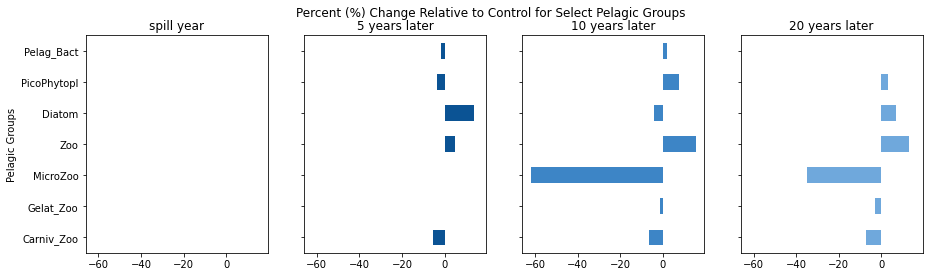

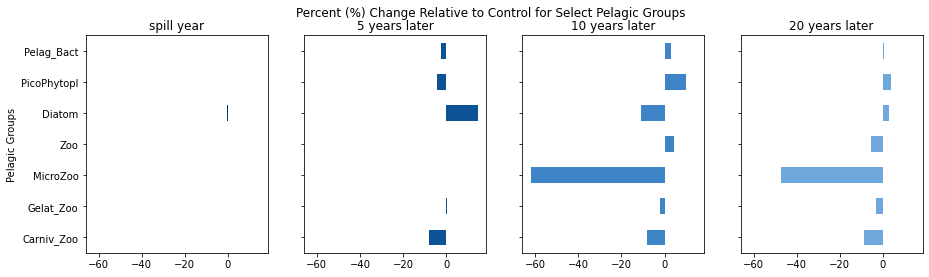

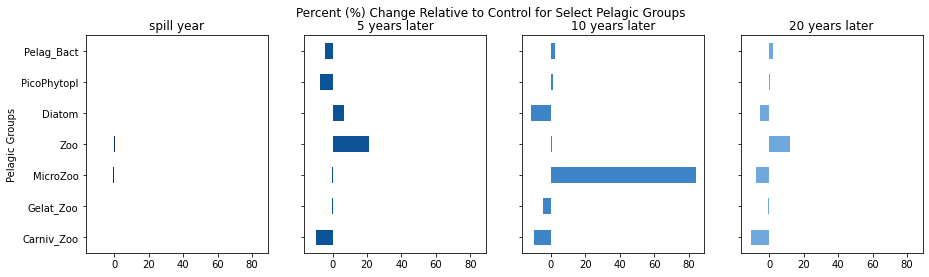

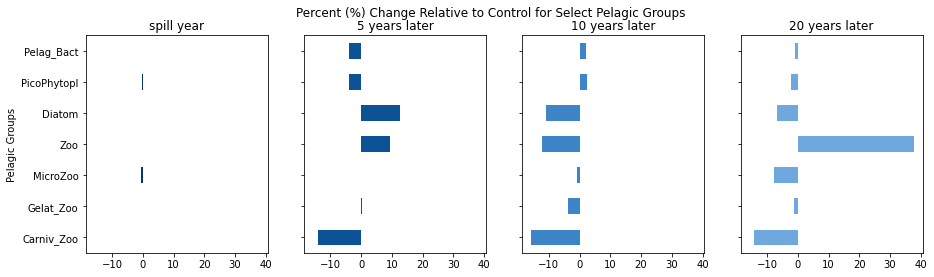

In [22]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.plankton,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.plankton,scenario,control,days2020winter,data_label)

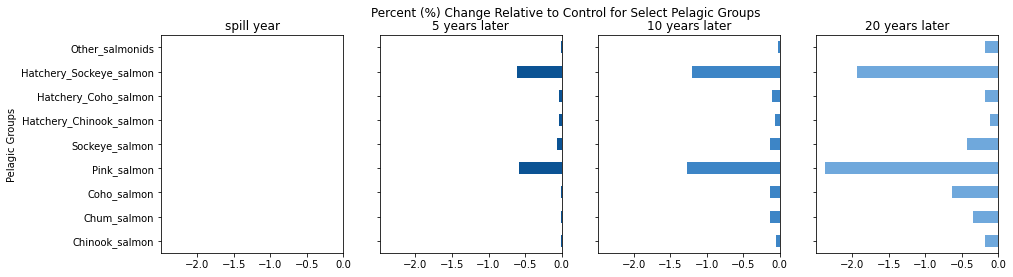

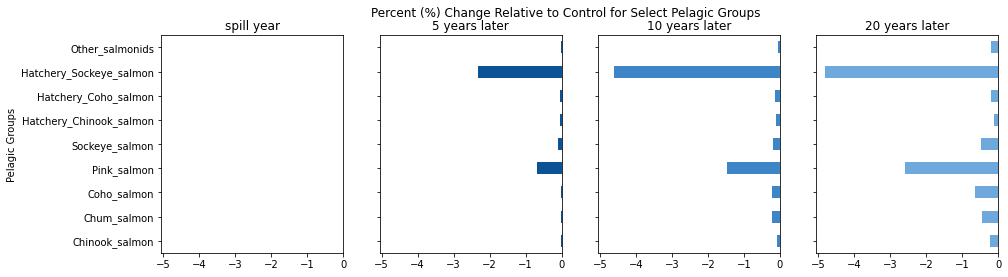

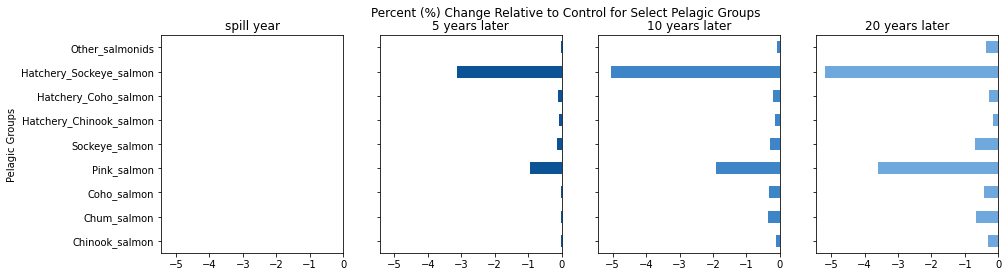

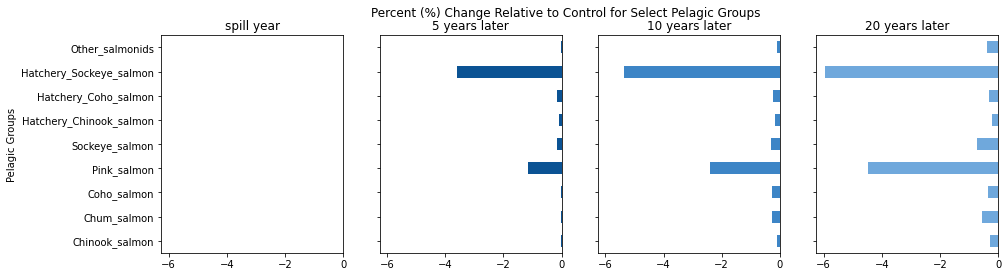

In [23]:

for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.salmon,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.salmon,scenario,control,days2020winter,data_label)

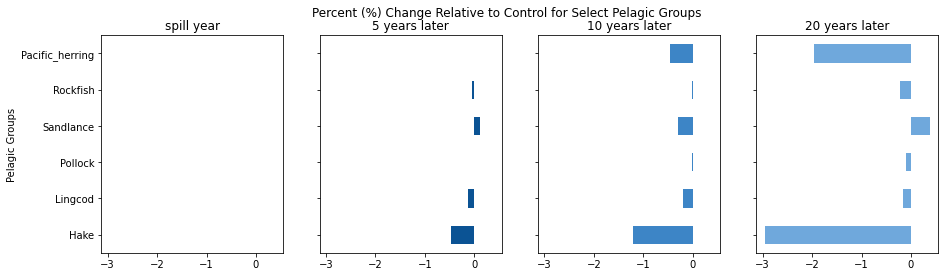

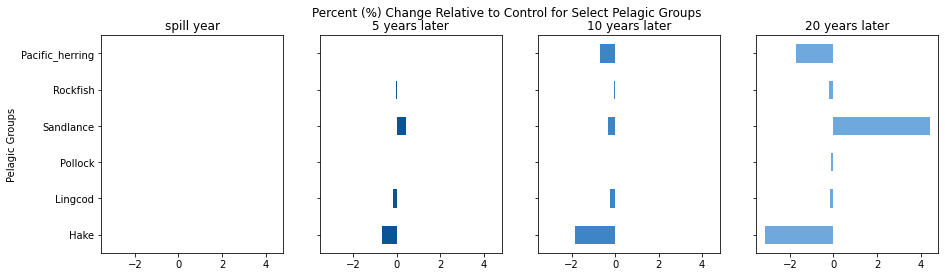

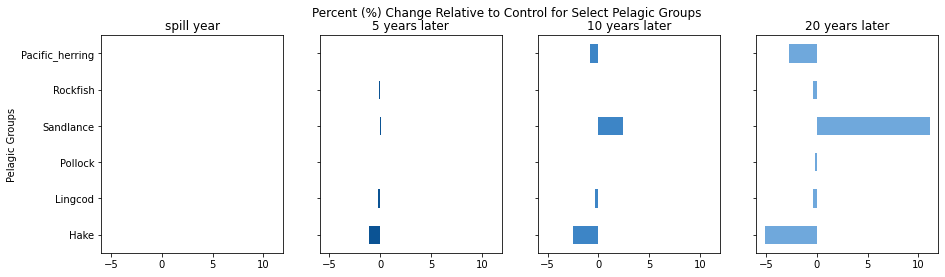

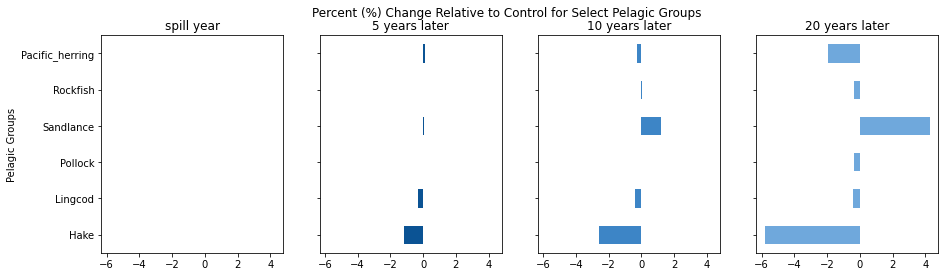

In [24]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.named_fish,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.named_fish,scenario,control,days2020winter,data_label)

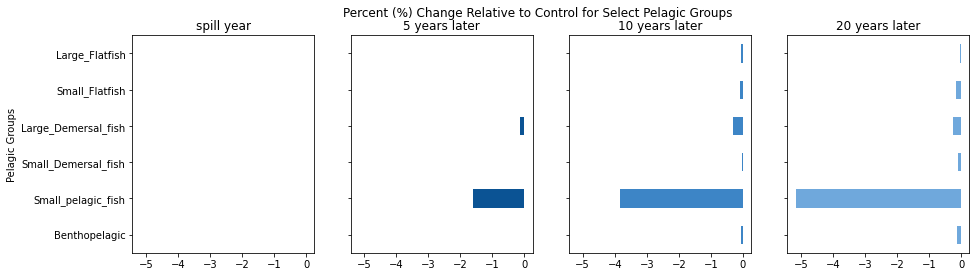

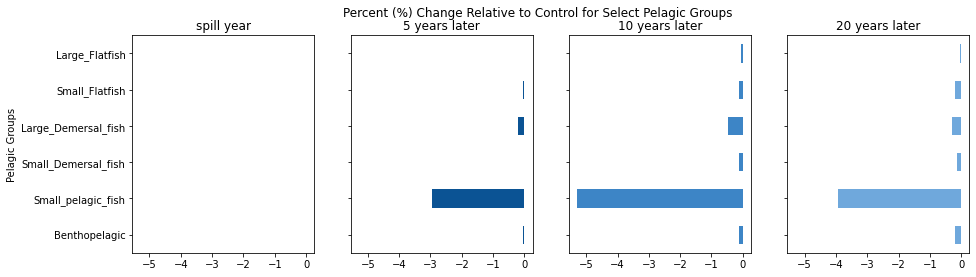

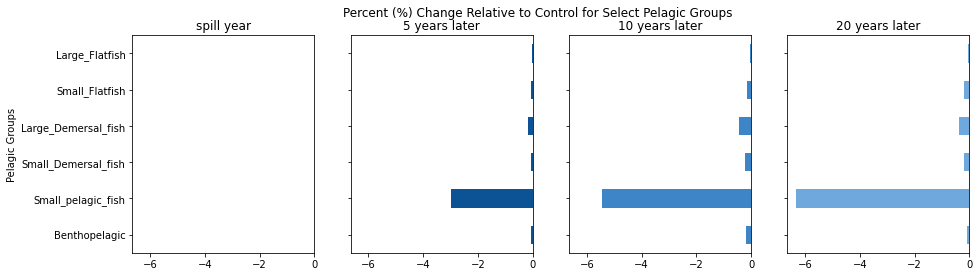

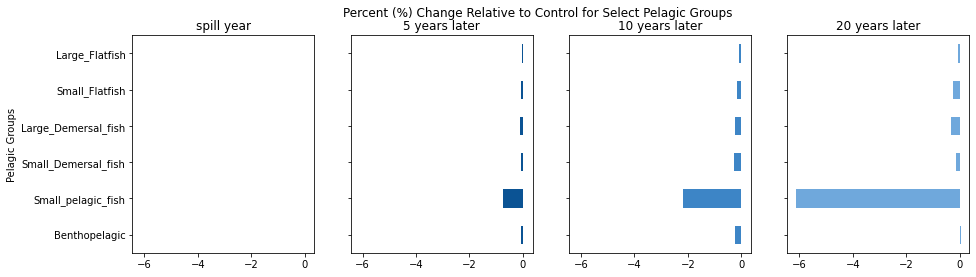

In [25]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.other_fish,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.other_fish,scenario,control,days2020winter,data_label)

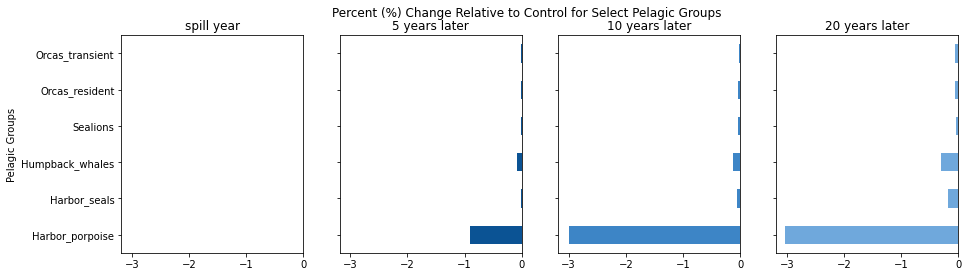

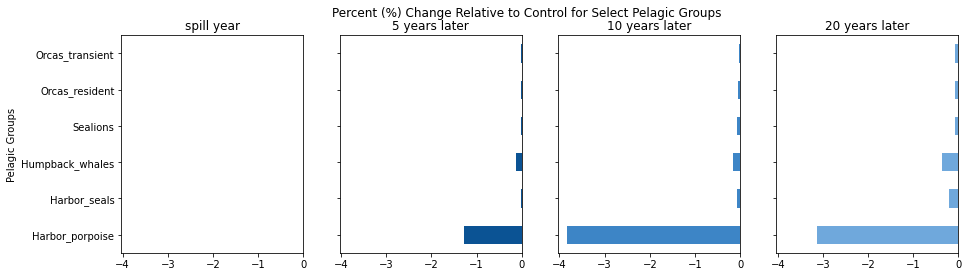

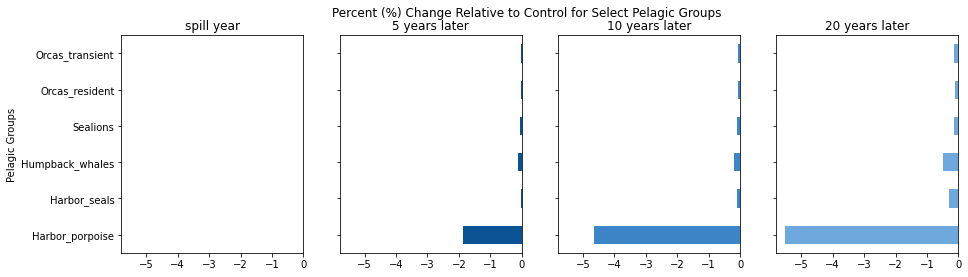

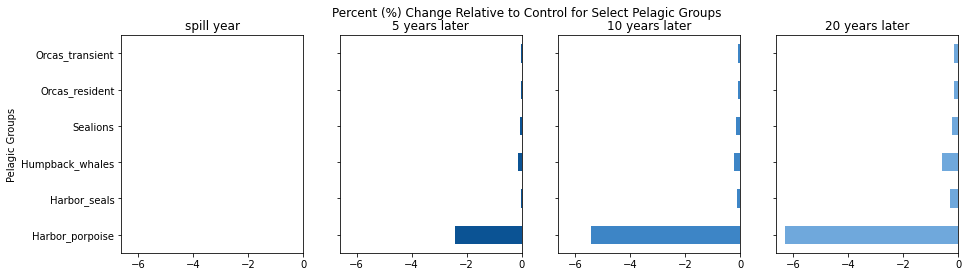

In [26]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.mammals,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.mammals,scenario,control,days2020winter,data_label)

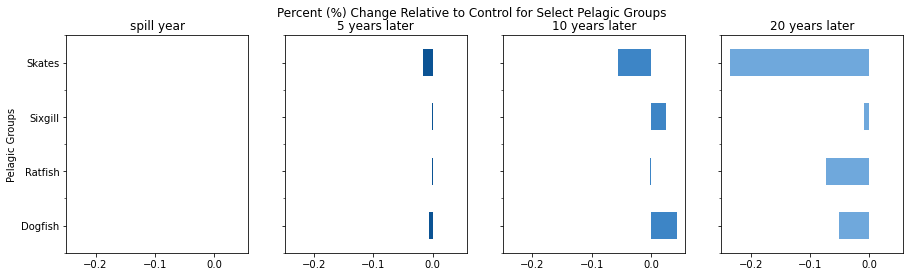

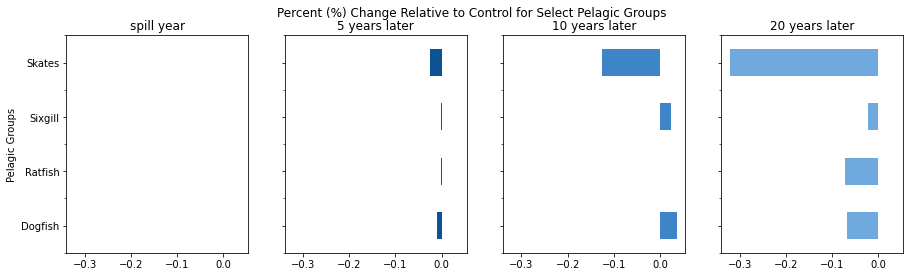

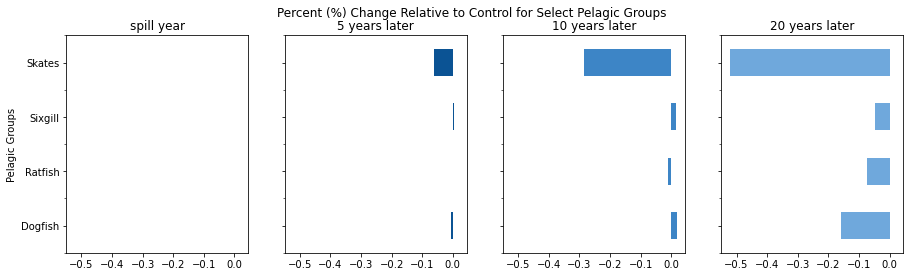

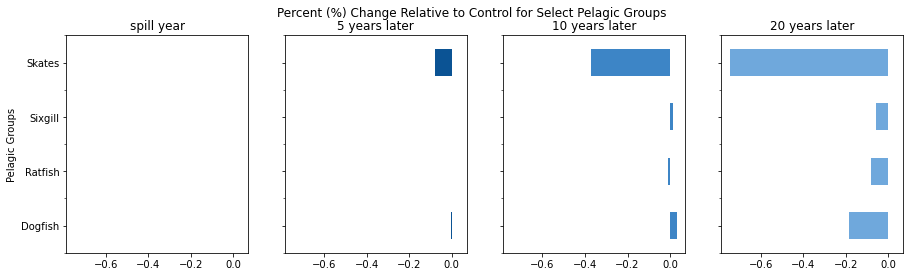

In [27]:
for scenario in scenarios2019:
    splot.boxplot_pelagic(groups.sharks,scenario,control,days2019winter,data_label)

for scenario in scenarios2020:
    splot.boxplot_pelagic(groups.sharks,scenario,control,days2020winter,data_label)

### Map display

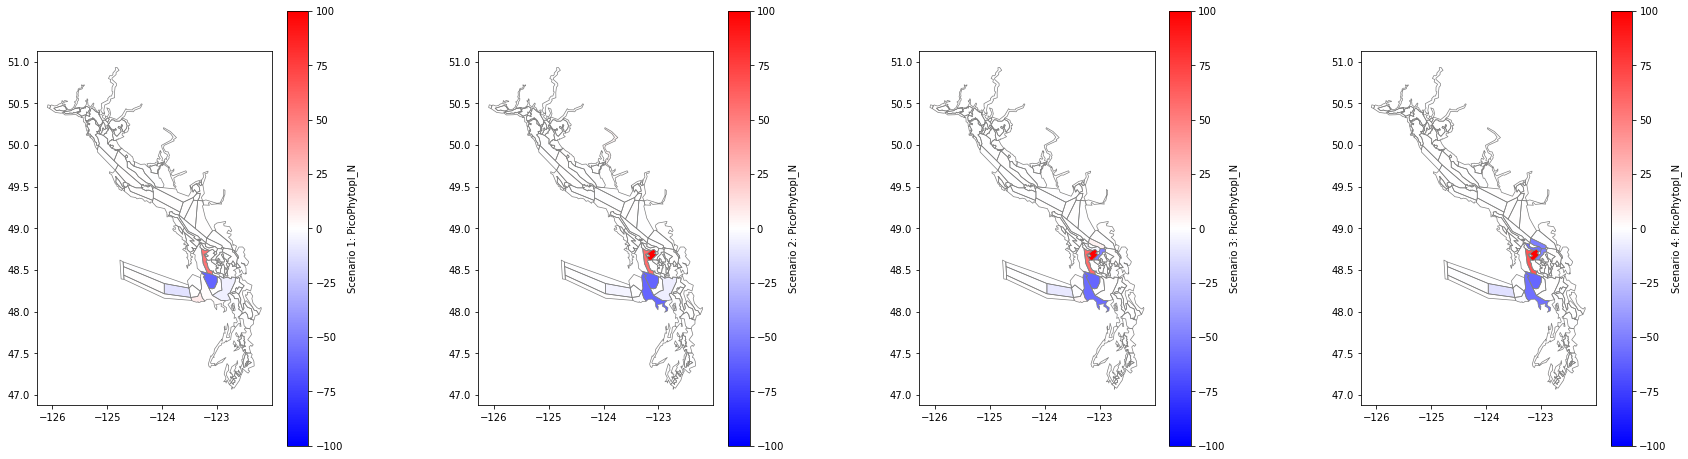

In [31]:
splot.map_pelagic_aggregate_time4('PicoPhytopl_N', scenario1, scenario2, scenario3, scenario4, control, v_max=100, v_min=-100)

Pulling data from the outputSalishSeaBiomIndx.txt file

In [ ]:

df = pd.DataFrame(columns = ['scenario 1', 'scenario 2', 'scenario 3', 'scenario 4'])

scen_path = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
scens = sorted([p for p in scen_path.glob('*Scenario_5b*/outputSalishSeaBiomIndx.txt')])
for path in scens:
    biomass = pd.read_csv(path, sep=" ")
    df.append(biomass.PS)

fig, ax = plt.subplots()
data.plot.barh(ax=ax)  # ax=ax lets the dataframe plot use the subplot axes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');  # place the legend outside

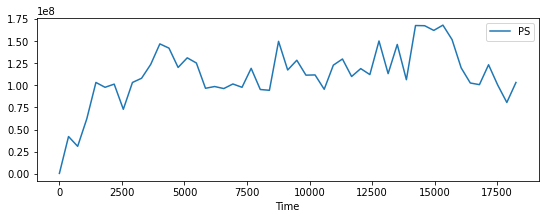

In [32]:
control_data_path = '/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/control_v6666mod/outputSalishSeaBiomIndx.txt'
contr = pd.read_csv(control_data_path, sep=" ")
contr.plot('Time','PS', figsize=(9, 3));